In [3]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
import torchvision
import pathlib
from pick_place.utils.configs import Configs

device = 5
# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("/data/brightmachines/ckpts/dino/")
# update below to use different model checkpoints
ckpt = ckpt_path / "scnn_dino_scnn_0.59.pth"
config = ckpt_path / "dino.yml"

scnn_config  = Configs.load_config(config)
train_data, val_data, test_data = Configs.load_dataset(scnn_config)

image = train_data[0][0]

processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb8')
model = ViTModel.from_pretrained('facebook/dino-vitb8')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
emb = outputs.last_hidden_state
print(emb.shape)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 785, 768])


In [14]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/dino-vits8", size=720)
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([1, 3, 720, 720])


In [15]:
from transformers import ViTModel

model = ViTModel.from_pretrained("facebook/dino-vits8", add_pooling_layer=False)

In [16]:
outputs = model(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

In [46]:
attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

torch.Size([6, 8100])


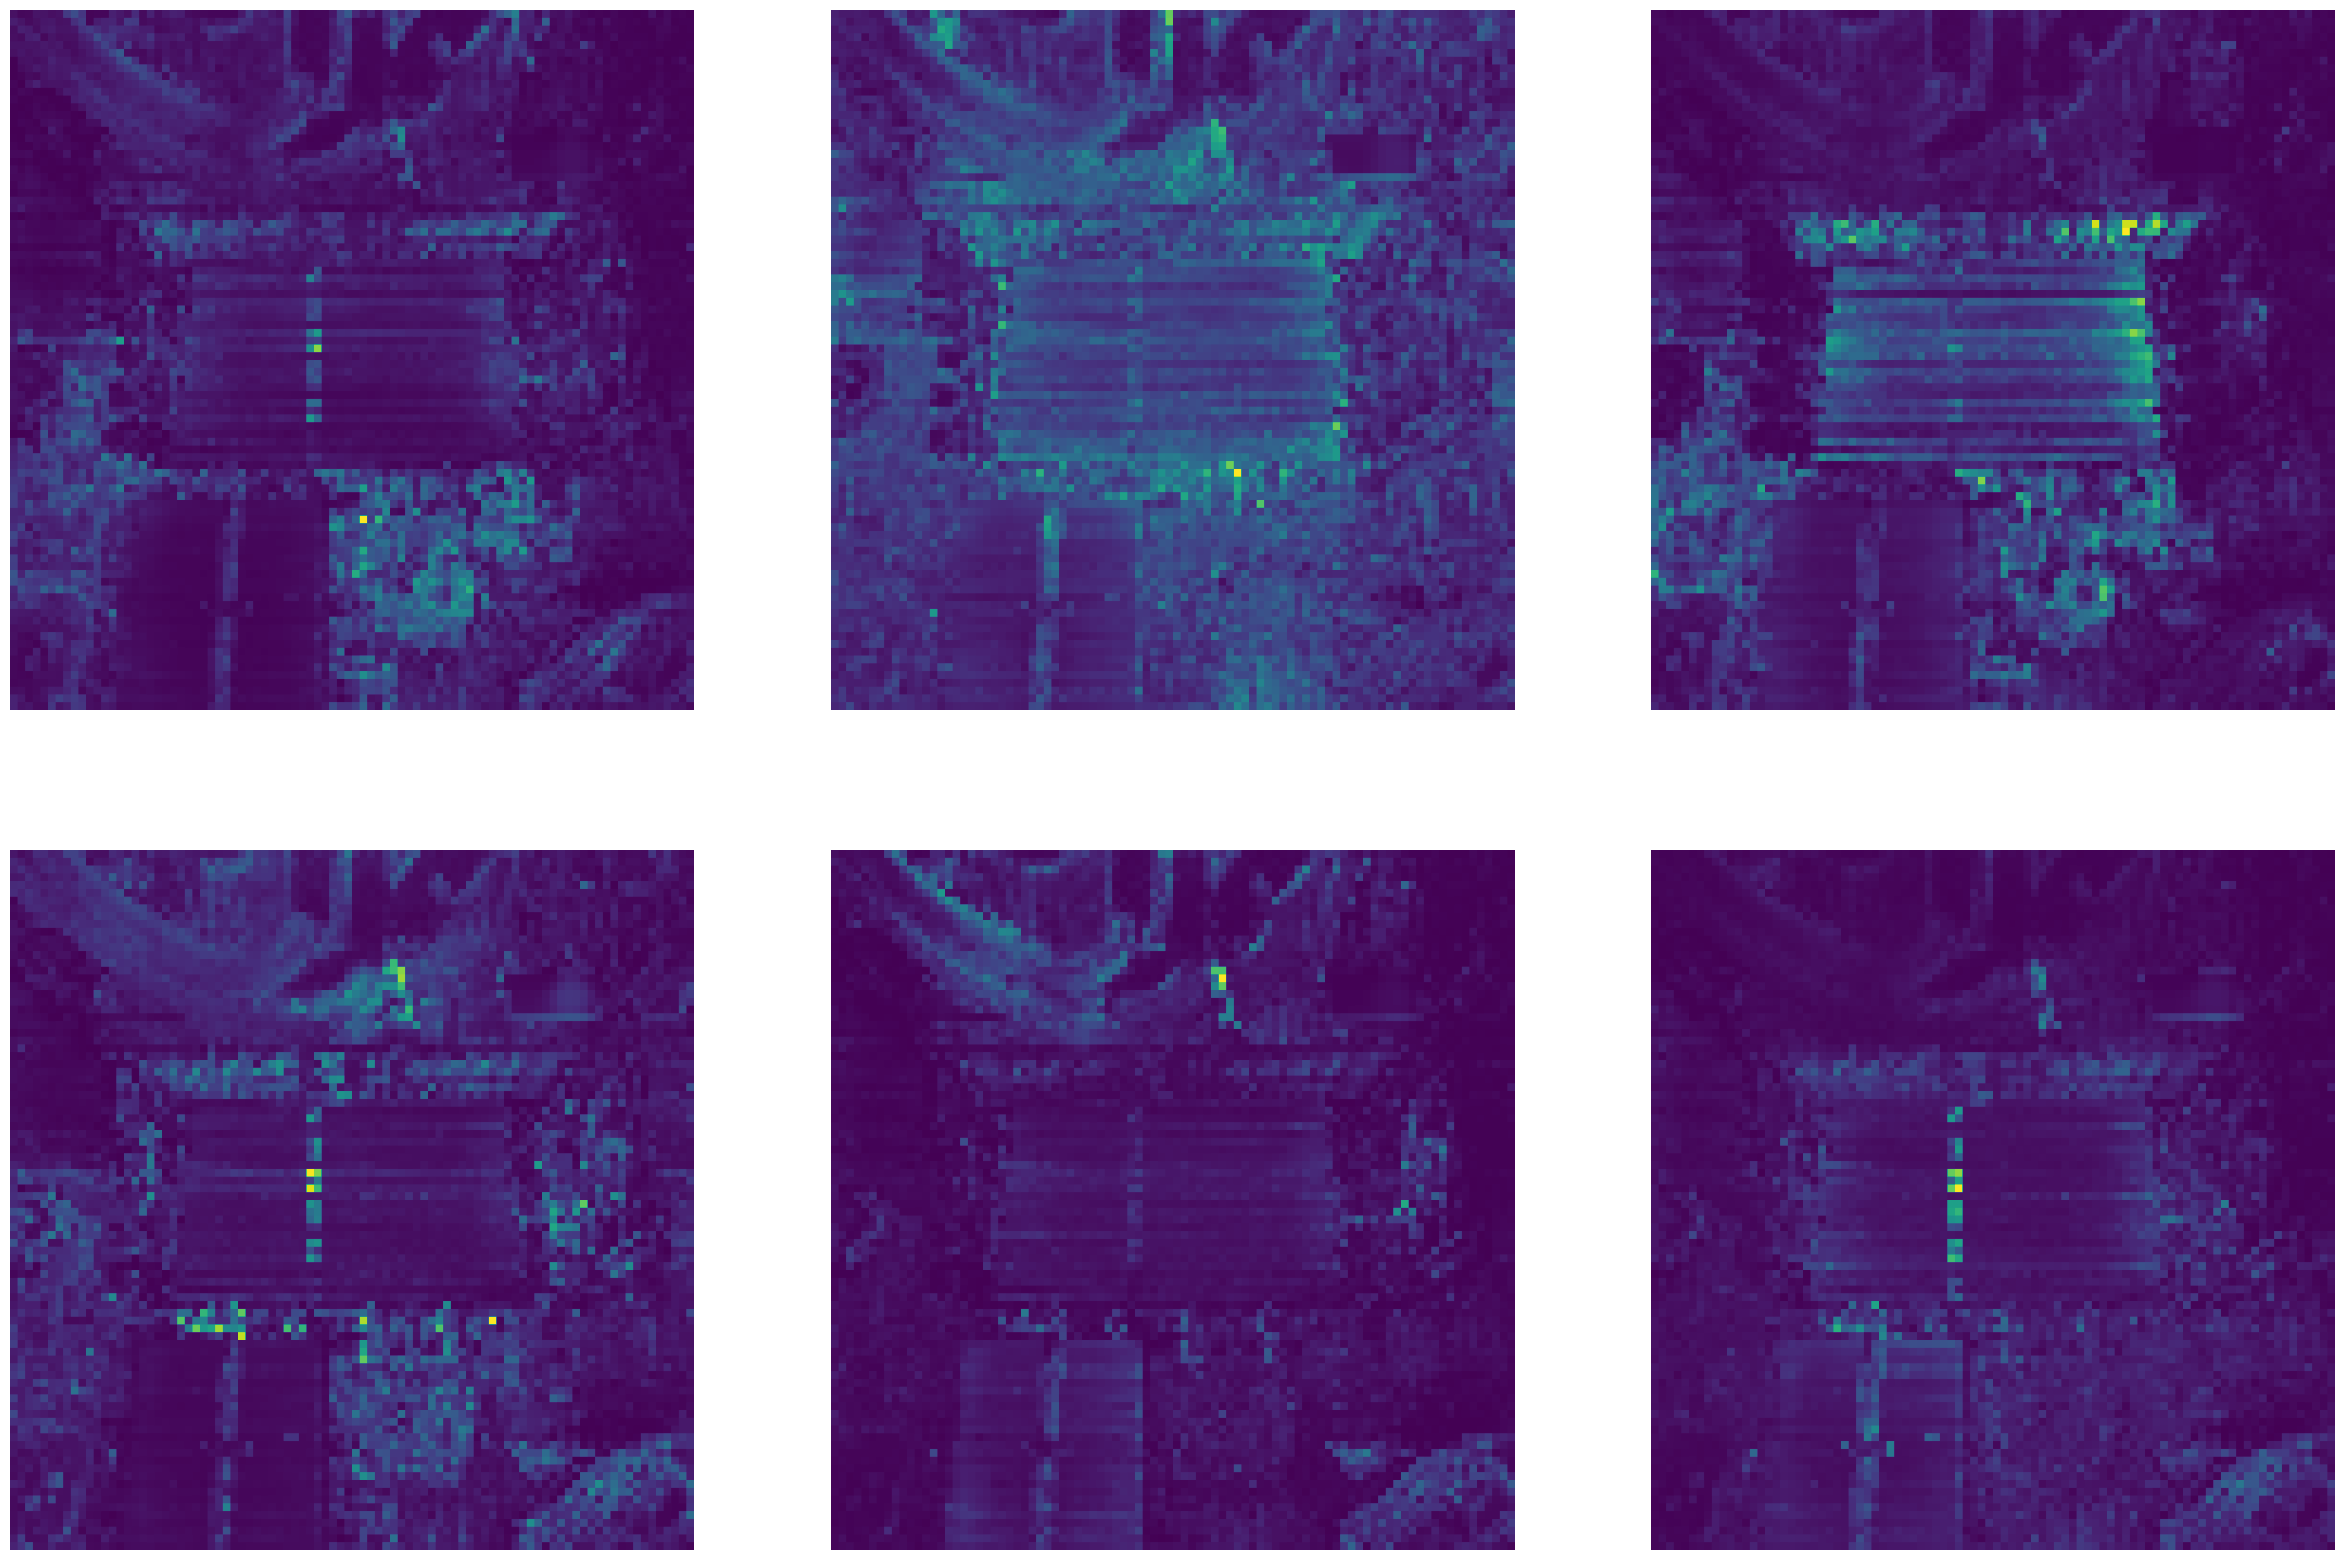

In [47]:
import os
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

threshold = 0.6
w_featmap = pixel_values.shape[-2] // model.config.patch_size
h_featmap = pixel_values.shape[-1] // model.config.patch_size

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()
attentions = attentions.detach().numpy()

# show and save attentions heatmaps
output_dir = '.'
os.makedirs(output_dir, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))


fig, axs = plt.subplots(2, nh // 2, figsize=(30, 20))
num = 0
for j in range(nh):
    fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    x = 0 if j < nh / 2 else 1
    axs[x][j % 3].imshow(attentions[j], aspect='auto')
    axs[x][j % 3].axis('off')
    #plt.imsave(fname=fname, arr=attentions[j], format='png')
    #print(f"{fname} saved.")